# ML for Insights Challenge
This is day 2 of the ML for Insights challenge.

The earlier parts of the challenge are:
0. Use Cases for ML Insights: **[Tutorial](https://www.kaggle.com/dansbecker/use-cases-for-model-insights)**
1. Permutation Importance: **[Tutorial](https://www.kaggle.com/dansbecker/permutation-importance) - [Exercise](https://www.kaggle.com/dansbecker/exercise-permutation-importance)**


# Partial Dependence Plots

While feature importance shows what variables most affect predictions, partial dependence plots show *how* a feature affects predictions.

This is useful to answer questions like:

* Controlling for all other house features, what impact do longitude and latitude have on home prices? To restate this, how would similarly sized houses be priced in different areas?

* Are predicted health differences between two groups due to differences in their diets, or due to some other factor?

If you are familiar with linear or logistic regression models, partial dependence plots can be interepreted similarly to the coefficients in those models.  Though, partial dependence plots on sophisticated models can capture more complex patterns than coefficients from simple models.  If you aren't familiar with linear or logistic regressions, don't worry about this comparison.

We will show a couple examples, explain the interpretation of these plots, and then review the code to create these plots.

# How it Works

Like permutation importance, **partial dependence plots are calculated after a model has been fit.**  The model is fit on real data that has not been artificially manipulated in any way.  

In our soccer example, teams may differ in many ways. How many passes they made, shots they took, goals they scored, etc. At first glance, it seems difficult to disentangle the effect of these features.

To see how partial plots separate out the effect of each feature, we start by considering a single row of data. For example, that row of data might represent a team that had the ball 50% of the time, made 100 passes, took 10 shots and scored 1 goal.

We will use the fitted model to predict our outcome (probability their player won "man of the game"). But we **repeatedly alter the value for one variable** to make a series of predictions.  We could predict the outcome if the team had the ball only 40% of the time. We then predict with them having the ball 50% of the time.  Then predict again for 60%.  And so on.  We trace out predicted outcomes (on the vertical axis) as we move from small values of ball possession to large values (on the horizontal axis).

In this description, we used only a single row of data.  Interactions between features may cause the plot for a single row to be atypical.  So, we repeat that mental experiment with multiple rows from the original dataset, and we plot the average predicted outcome on the vertical axis.  

# Code Example

Model building isn't our focus, so we won't focus on the data exploration or model building code.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

data = pd.read_csv('FIFA 2018 Statistics.csv')
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(train_X, train_y)

/home/mutsuhiro/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


For the sake of explanation, our first example uses a Decision Tree which you can see below. In practice, you'll use more sophistated models for real-world applications.

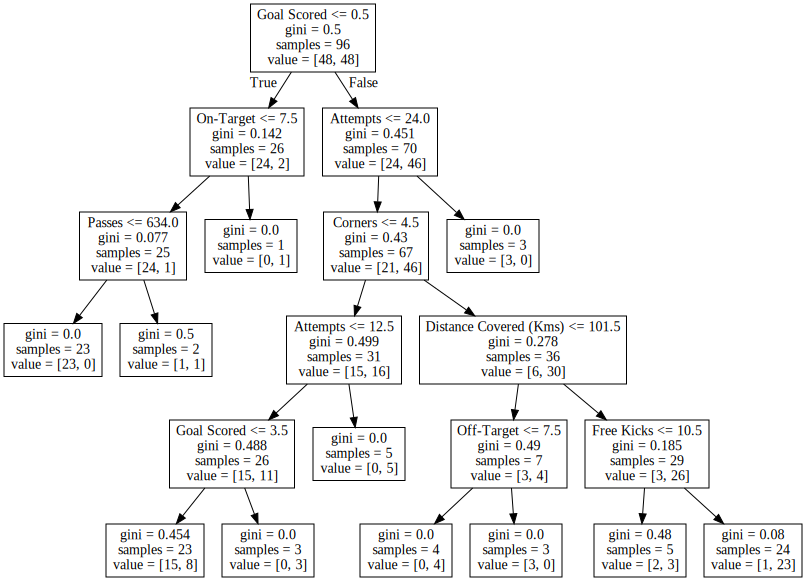

In [2]:
from sklearn import tree
import graphviz

tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=feature_names)
graphviz.Source(tree_graph)

As guidance to read the tree:
- Leaves with children show their splitting criterion on the top
- The pair of values at the bottom show the count of True values and False values for the target respectively, of data points in that node of the tree.


Here is the code to create the Partial Dependence Plot using the [PDPBox library](https://pdpbox.readthedocs.io/en/latest/).

In [3]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=feature_names, feature='Goal Scored')

# plot it
pdp.pdp_plot(pdp_goals, 'Goal Scored')
plt.show()

<Figure size 1500x950 with 2 Axes>

A few items are worth pointing out as you interpret this plot
- The y axis is interpreted as **change in the prediction** from what it would be predicted at the baseline or leftmost value.
- A blue shaded area indicates level of confidence

From this particular graph, we see that scoring a goal substantially increases your chances of winning "Player of The Game."  But extra goals beyond that appear to have little impact on predictions.

Here is another example plot:

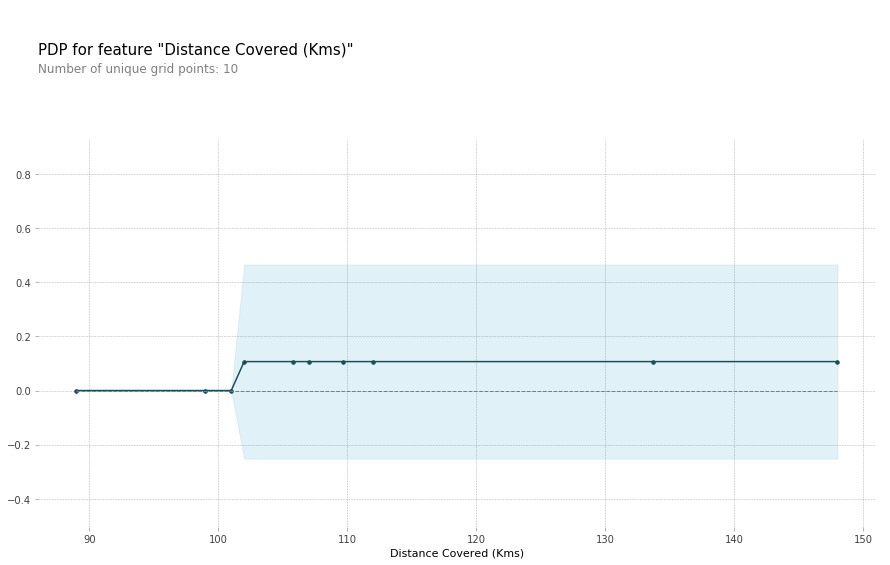

In [4]:
feature_to_plot = 'Distance Covered (Kms)'
pdp_dist = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=feature_names, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

This graph seems too simple to represent reality. But that's because the model is so simple. You should be able to see from the decision tree above that this is representing exactly the model's structure.

You can easily compare the structure or implications of different models. Here is the same plot with a Random Forest model.

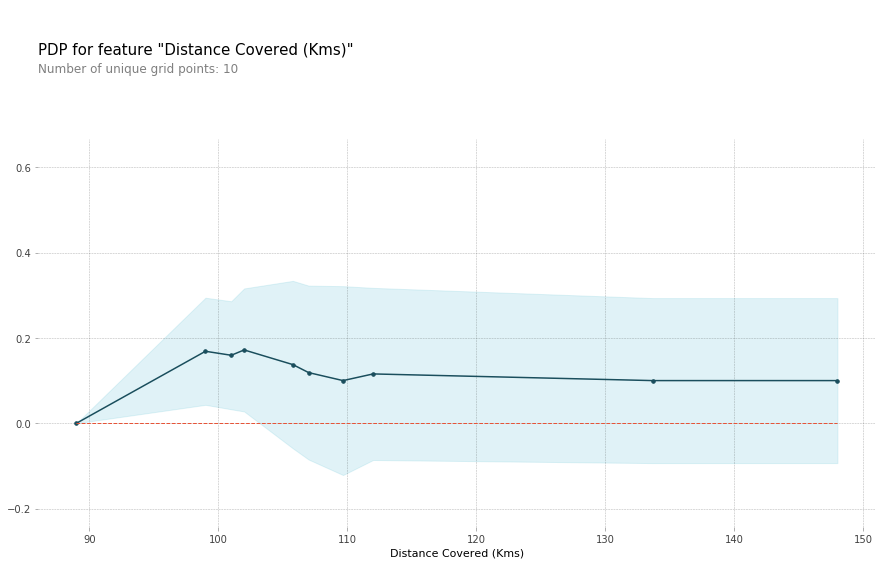

In [5]:
# Build Random Forest model
rf_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

pdp_dist = pdp.pdp_isolate(model=rf_model, dataset=val_X, model_features=feature_names, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

This model thinks you are more likely to win *Player of The Game* if your players run a total of 100km over the course of the game. Though running much more causes lower predictions.

In general, the smooth shape of this curve seems more plausible than the step function from the Decision Tree model.  Though this dataset is small enough that we would be careful in how we interpret any model.

# 2D Partial Dependence Plots
If you are curious about interactions between features, 2D partial dependence plots are also useful. An example may clarify what this.  

We will again use the Decision Tree model for this graph.  It will create an extremely simple plot, but you should be able to match what you see in the plot to the tree itself.


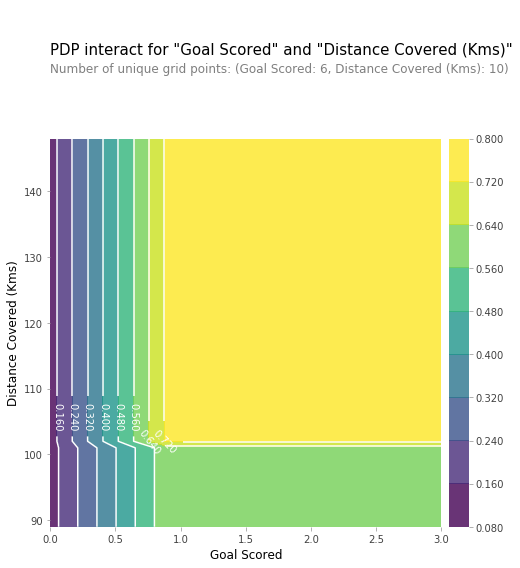

In [6]:
# Similar to previous PDP plot except we use pdp_interact instead of pdp_isolate and pdp_interact_plot instead of pdp_isolate_plot
features_to_plot = ['Goal Scored', 'Distance Covered (Kms)']
inter1  =  pdp.pdp_interact(model=tree_model, dataset=val_X, model_features=feature_names, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

This graph shows predictions for any combination of Goals Scored and Distance covered. 

For example, we see the highest predictions when a team scores at least 1 goal and they run a total distance close to 100km.  If they score 0 goals, distance covered doesn't matter. Can you see this by tracing through the decision tree with 0 goals?

But distance can impact predictions if they score goals. Make sure you can see this from the 2D partial dependence plot. Can you see this pattern in the decision tree too?

# Your Turn
**[Test your understanding](https://www.kaggle.com/kernels/fork/1637380)** on conceptual questions and a short coding challenge.
